In [ ]:
# movielens dataset generation for GCN

In [1]:
import os
import time
import argparse
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn
from tensorboardX import SummaryWriter

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
raw = pd.read_csv('./rawdata/ratings.dat', sep = "::", header = None)

/tmp/ipykernel_18287/555006589.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  raw = pd.read_csv('./rawdata/ratings.dat', sep = "::", header = None)


In [3]:
raw.columns = ['uid', 'sid', 'ratings', 'timestamp']

In [4]:
raw = raw[['uid', 'sid']]

In [5]:
new_items = raw.sid.value_counts()[raw.sid.value_counts() >= 10].reset_index()['index'].values

In [6]:
data2 = raw[raw.sid.isin(new_items)]
data2 = data2.reset_index()[['uid', 'sid']]

### Popularity Count 에 따라 index 재정렬

In [7]:
pop_uid = data2.uid.value_counts().reset_index()
pop_uid.columns = ['uid', 'uid_counts']

In [8]:
pop_uid_dict = pop_uid.reset_index()
pop_uid_dict = pop_uid_dict[['index', 'uid']]
pop_uid_dict.columns = ['new_uid', 'uid']

pop_uid_dict = dict(zip(pop_uid_dict.uid, pop_uid_dict.new_uid))

In [9]:
pop_sid = data2.sid.value_counts().reset_index()
pop_sid.columns = ['sid', 'sid_counts']

In [10]:
pop_sid_dict = pop_sid.reset_index()
pop_sid_dict = pop_sid_dict[['index', 'sid']]
pop_sid_dict.columns = ['new_sid', 'sid']

pop_sid_dict = dict(zip(pop_sid_dict.sid, pop_sid_dict.new_sid))

In [11]:
data2['uid'] = data2.uid.map(pop_uid_dict).values
data2['sid'] = data2.sid.map(pop_sid_dict).values

In [12]:
data2 = data2.sort_values(['uid', 'sid'], ascending = [True, True])

In [13]:
tmp = data2
tmp['one'] = 1

In [14]:
import seaborn as sns

<AxesSubplot:xlabel='sid', ylabel='uid'>

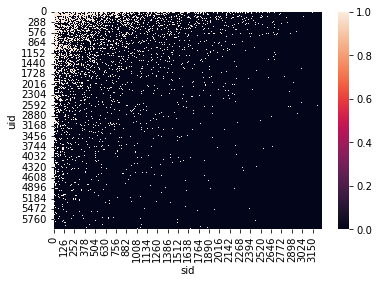

In [15]:
sns.heatmap(tmp.pivot_table(index = 'uid', columns = 'sid', values = 'one', fill_value = 0))

In [16]:
data2 = data2.reset_index()[['uid', 'sid']]

In [17]:
total_data = data2

In [19]:
total_data = total_data.reset_index()[['uid', 'sid']]

### test data split

In [20]:
import random
random.seed(0)

train_df = total_data.sample(frac = 0.8, random_state = 0)
test_df = total_data.loc[list(set(total_data.index) - set(train_df.index)) ]

In [21]:
print(len(total_data.uid.unique()))
print(len(total_data.sid.unique()))
print(' ')
print(len(train_df.uid.unique()))
print(len(train_df.sid.unique()))
print(' ')
print(len(test_df.uid.unique()))
print(len(test_df.sid.unique()))


6040
3260
 
6040
3260
 
6036
3244


In [22]:
print(total_data.uid.value_counts().tail())
print(total_data.sid.value_counts().tail())

6036    19
6035    19
6034    19
6038    18
6039    17
Name: uid, dtype: int64
3234    10
3258    10
3235    10
3233    10
3244    10
Name: sid, dtype: int64


In [23]:
print(train_df.uid.value_counts().tail())
print(train_df.sid.value_counts().tail())

5998    13
6026    13
5931    13
6039    12
5755    11
Name: uid, dtype: int64
3246    6
3218    6
3249    5
3195    5
3259    5
Name: sid, dtype: int64


In [34]:
print(test_df.uid.value_counts().tail())
print(test_df.sid.value_counts().tail())

4883    1
5884    1
5972    1
5658    1
5550    1
Name: uid, dtype: int64
3112    1
3096    1
3248    1
3159    1
3028    1
Name: sid, dtype: int64


In [24]:
train_df

,uid,sid
383115,611,497
209564,251,746
66909,58,47
76129,68,396
155138,168,168
...,...,...
973531,5070,20
545928,1112,130
95085,90,413
827821,2768,1800


In [25]:
test_df

,uid,sid
1,0,1
524289,1034,765
524291,1034,782
4,0,4
524297,1034,828
...,...,...
524254,1034,544
524265,1034,612
524268,1034,637
524272,1034,675


### Make 'test' negative sample

In [26]:
random.seed(0)

n_user = len(total_data.uid.unique())
n_item = len(total_data.sid.unique())

item_set = set(list(range(n_item)))
neg_sample_df = pd.DataFrame({'uid' : [], 'sid' : []})

for user in list(range(n_user)):
    true_set = total_data[total_data['uid'] == user]['sid'].values
    true_set = set(true_set)
    user_neg_samples = item_set - true_set
    user_neg_samples = list(user_neg_samples)
    
    list_len = len(user_neg_samples)
    user_neg_samples = random.sample(user_neg_samples, 100)
    tmp_neg_sample_df = pd.DataFrame({'uid' : [user]*100, 'sid' : user_neg_samples})
    
    neg_sample_df = pd.concat([neg_sample_df, tmp_neg_sample_df])

In [27]:
neg_sample_df

,uid,sid
0,0.0,1402.0
1,0.0,1639.0
2,0.0,2270.0
3,0.0,3006.0
4,0.0,1948.0
...,...,...
95,6039.0,2188.0
96,6039.0,1309.0
97,6039.0,2891.0
98,6039.0,533.0


In [28]:
neg_sample_df['uid'] = neg_sample_df['uid'].astype(int)
neg_sample_df['sid'] = neg_sample_df['sid'].astype(int)

In [29]:
test_df['type'] = 'pos'
neg_sample_df['type'] = 'neg'

In [30]:
test_df

,uid,sid,type
1,0,1,pos
524289,1034,765,pos
524291,1034,782,pos
4,0,4,pos
524297,1034,828,pos
...,...,...,...
524254,1034,544,pos
524265,1034,612,pos
524268,1034,637,pos
524272,1034,675,pos


In [31]:
neg_sample_df

,uid,sid,type
0,0,1402,neg
1,0,1639,neg
2,0,2270,neg
3,0,3006,neg
4,0,1948,neg
...,...,...,...
95,6039,2188,neg
96,6039,1309,neg
97,6039,2891,neg
98,6039,533,neg


In [32]:
test_neg_sample_df = neg_sample_df.copy()
test_df_with_neg = pd.concat([test_df, neg_sample_df])

In [33]:
test_df_with_neg

,uid,sid,type
1,0,1,pos
524289,1034,765,pos
524291,1034,782,pos
4,0,4,pos
524297,1034,828,pos
...,...,...,...
95,6039,2188,neg
96,6039,1309,neg
97,6039,2891,neg
98,6039,533,neg


In [34]:
train_df

,uid,sid
383115,611,497
209564,251,746
66909,58,47
76129,68,396
155138,168,168
...,...,...
973531,5070,20
545928,1112,130
95085,90,413
827821,2768,1800


In [35]:
train_df = train_df.reset_index()[['uid', 'sid']]

In [36]:
test_df = test_df.reset_index()[['uid', 'sid', 'type']]

In [38]:
### neg_sample_df == test_neg_sample_df
neg_sample_df = neg_sample_df.reset_index()[['uid', 'sid', 'type']]

In [39]:
test_df_with_neg = test_df_with_neg.reset_index()[['uid', 'sid', 'type']]

In [40]:
train_df

,uid,sid
0,611,497
1,251,746
2,58,47
3,68,396
4,168,168
...,...,...
798826,5070,20
798827,1112,130
798828,90,413
798829,2768,1800


### val data split

In [41]:
real_train_df = train_df.sample(frac = 0.75, random_state = 0)

In [42]:
val_df = train_df.loc[list(set(train_df.index) - set(real_train_df.index)) ]

In [43]:
real_train_df

,uid,sid
698519,660,203
1097,941,1038
453535,451,281
38882,4633,1113
422735,926,581
...,...,...
593974,651,1335
703961,4381,294
452675,2544,145
535606,1290,377


In [44]:
val_df

,uid,sid
524288,1838,1828
1,251,746
524289,718,403
524291,1164,304
4,168,168
...,...,...
524265,53,796
524268,2367,1258
524272,5461,532
524274,447,85


In [45]:
val_df['type'] = 'pos'

In [46]:
val_df_with_neg = pd.concat([val_df, neg_sample_df])

In [47]:
val_df_with_neg

,uid,sid,type
524288,1838,1828,pos
1,251,746,pos
524289,718,403,pos
524291,1164,304,pos
4,168,168,pos
...,...,...,...
603995,6039,2188,neg
603996,6039,1309,neg
603997,6039,2891,neg
603998,6039,533,neg


In [48]:
real_train_df = real_train_df.reset_index()[['uid', 'sid']]
val_df = val_df.reset_index()[['uid', 'sid', 'type']]
val_df_with_neg = val_df_with_neg.reset_index()[['uid', 'sid', 'type']]

### 정리

In [49]:
total_data

,uid,sid
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
998534,6039,743
998535,6039,757
998536,6039,1043
998537,6039,1816


In [50]:
real_train_df

,uid,sid
0,660,203
1,941,1038
2,451,281
3,4633,1113
4,926,581
...,...,...
599118,651,1335
599119,4381,294
599120,2544,145
599121,1290,377


In [51]:
neg_sample_df

,uid,sid,type
0,0,1402,neg
1,0,1639,neg
2,0,2270,neg
3,0,3006,neg
4,0,1948,neg
...,...,...,...
603995,6039,2188,neg
603996,6039,1309,neg
603997,6039,2891,neg
603998,6039,533,neg


In [52]:
val_df

,uid,sid,type
0,1838,1828,pos
1,251,746,pos
2,718,403,pos
3,1164,304,pos
4,168,168,pos
...,...,...,...
199703,53,796,pos
199704,2367,1258,pos
199705,5461,532,pos
199706,447,85,pos


In [54]:
val_df_with_neg

,uid,sid,type
0,1838,1828,pos
1,251,746,pos
2,718,403,pos
3,1164,304,pos
4,168,168,pos
...,...,...,...
803703,6039,2188,neg
803704,6039,1309,neg
803705,6039,2891,neg
803706,6039,533,neg


In [55]:
val_df.type.value_counts()

pos    199708
Name: type, dtype: int64

In [56]:
val_df_with_neg.type.value_counts()

neg    604000
pos    199708
Name: type, dtype: int64

In [57]:
test_df = test_df[['uid', 'sid', 'type']]

In [58]:
test_df_with_neg = test_df_with_neg[['uid', 'sid', 'type']]

In [59]:
test_df.type.value_counts()

pos    199708
Name: type, dtype: int64

In [60]:
test_df_with_neg.type.value_counts()

neg    604000
pos    199708
Name: type, dtype: int64

In [61]:
total_data.shape[0] == real_train_df.shape[0] + val_df.shape[0] + test_df.shape[0]

True

In [62]:
val_df_with_neg.shape[0] == val_df.shape[0] + neg_sample_df.shape[0]

True

In [63]:
test_df_with_neg.shape[0] == test_df.shape[0] + neg_sample_df.shape[0]

True

In [64]:
total_data.to_csv('total_df', index = False)
real_train_df.to_csv('train_df', index = False)
neg_sample_df.to_csv('neg_sample_df', index = False)

val_df.to_csv('val_df', index = False)
val_df_with_neg.to_csv('val_df_with_neg', index = False)

test_df.to_csv('test_df', index = False)
test_df_with_neg.to_csv('test_df_with_neg', index = False)

In [65]:
uid_pop_total = total_data.uid.value_counts().reset_index()
uid_pop_total.columns = ['uid', 'total_counts']

sid_pop_total = total_data.sid.value_counts().reset_index()
sid_pop_total.columns = ['sid', 'total_counts']

In [66]:
uid_pop_train = train_df.uid.value_counts().reset_index()
uid_pop_train.columns = ['uid', 'train_counts']

sid_pop_train = train_df.sid.value_counts().reset_index()
sid_pop_train.columns = ['sid', 'train_counts']

In [67]:
uid_pop_total.to_csv('uid_pop_total', index = False)
sid_pop_total.to_csv('sid_pop_total', index = False)

uid_pop_train.to_csv('uid_pop_train', index = False)
sid_pop_train.to_csv('sid_pop_train', index = False)